# Task 2: Bayesian Change Point Analysis
Complete implementation of Bayesian change point detection for Brent oil prices.

In [ ]:
import sys
from pathlib import Path

ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import json
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

print("=" * 70)
print("TASK 2: BAYESIAN CHANGE POINT ANALYSIS")
print("=" * 70)

TASK 2: BAYESIAN CHANGE POINT ANALYSIS


In [11]:
# 1. Load and Prepare Data
print("\n1. Loading and preparing data...")

from src.data_preprocessing import load_brent_data, calculate_returns, load_events_data

df_prices = load_brent_data("../data/raw/BrentOilPrices.csv")
df_returns = calculate_returns(df_prices)
df_events = load_events_data("../data/events/key_events.csv")

try:
    df_enhanced_events = pd.read_csv("../data/events/enhanced_events.csv")
    df_enhanced_events['Date'] = pd.to_datetime(df_enhanced_events['Date'])
    print("✓ Loaded enhanced events data")
except Exception:
    df_enhanced_events = df_events.copy()
    print("✓ Using standard events data")

print(f"Price data: {len(df_prices)} records ({df_prices['Date'].min().date()} to {df_prices['Date'].max().date()})")
print(f"Returns data: {len(df_returns)} records")
print(f"Events data: {len(df_events)} events")

log_returns = df_returns['Log_Returns'].values
return_dates = df_returns['Date']

print(f"\nLog returns statistics:")
print(f"  Mean: {log_returns.mean():.6f}")
print(f"  Std: {log_returns.std():.6f}")


1. Loading and preparing data...
✓ Loaded enhanced events data
Price data: 8360 records (1987-05-20 to 2020-04-21)
Returns data: 8359 records
Events data: 24 events

Log returns statistics:
  Mean: -0.000085
  Std: 0.024874


In [27]:
# 2. Define custom Bayesian analysis functions
print("\n2. Setting up Bayesian analysis...")

def build_simple_changepoint_model(data, model_name="single_cp"):
    """Build a simple change point model."""
    n = len(data)
    with pm.Model(name=model_name) as model:
        tau = pm.DiscreteUniform("tau", lower=1, upper=n-2)
        mu1 = pm.Normal("mu1", mu=0, sigma=0.1)
        mu2 = pm.Normal("mu2", mu=0, sigma=0.1)
        sigma1 = pm.HalfNormal("sigma1", sigma=0.1)
        sigma2 = pm.HalfNormal("sigma2", sigma=0.1)
        idx = np.arange(n)
        mu = pm.math.switch(idx < tau, mu1, mu2)
        sigma = pm.math.switch(idx < tau, sigma1, sigma2)
        pm.Normal("returns", mu=mu, sigma=sigma, observed=data)
    return model

def analyze_trace(trace):
    """Analyze MCMC trace."""
    print("\nTrace Analysis:")
    print("-" * 50)
    summary = az.summary(trace)
    print("\nParameter Summary:")
    print(summary)
    if 'r_hat' in summary.columns:
        rhat_max = summary['r_hat'].max()
        print(f"\nR-hat max: {rhat_max:.3f} {'✓' if rhat_max < 1.05 else '✗'}")
    else:
        print("\nR-hat not available in summary")
        rhat_max = 1.0
    if 'ess_bulk' in summary.columns:
        ess_min = summary['ess_bulk'].min()
        print(f"ESS min: {ess_min:.0f} {'✓' if ess_min > 400 else '✗'}")
    else:
        ess_min = 1000
    try:
        n_divergences = trace.sample_stats.diverging.sum().item()
        print(f"Divergences: {n_divergences} {'✓' if n_divergences == 0 else '✗'}")
    except Exception:
        n_divergences = 0
        print("Divergences: N/A")
    converged = (rhat_max < 1.05) and (ess_min > 400) and (n_divergences == 0)
    print(f"\nOverall convergence: {'✓' if converged else '✗'}")
    return {
        'summary': summary,
        'rhat_max': float(rhat_max),
        'ess_min': float(ess_min),
        'n_divergences': n_divergences,
        'converged': converged
    }

def plot_diagnostics(trace, model_name="single_cp", save_dir="../reports/task2"):
    """Plot diagnostic plots."""
    os.makedirs(save_dir, exist_ok=True)
    available_params = [var for var in trace.posterior.data_vars if not var.startswith(('chain', 'draw'))]
    print(f"\nAvailable parameters: {available_params}")
    base_params = []
    for param in available_params:
        base_params.append(param.split('::')[1] if '::' in param else param)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    for i, (full_param, base_param) in enumerate(zip(available_params[:4], base_params[:4])):
        ax = axes[i//2, i%2]
        try:
            param_data = trace.posterior[full_param].values
            if param_data.ndim >= 2:
                param_samples = param_data.reshape(-1, param_data.shape[-1]).flatten()
            else:
                param_samples = param_data.flatten()
            ax.plot(param_samples[:500], alpha=0.7, linewidth=1)
            ax.set_title(f"Trace: {base_param}", fontweight='bold')
            ax.set_xlabel('Sample')
            ax.set_ylabel('Value')
            ax.grid(True, alpha=0.3)
        except Exception:
            ax.text(0.5, 0.5, f"Error plotting\n{base_param}", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"Trace: {base_param}", fontweight='bold')
    plt.suptitle(f"Trace Plots - {model_name}", fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    trace_path = os.path.join(save_dir, f"{model_name}_trace_plots.png")
    plt.savefig(trace_path, dpi=150, bbox_inches='tight')
    print(f"✓ Trace plots saved to {trace_path}")
    plt.show()
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    for i, (full_param, base_param) in enumerate(zip(available_params[:4], base_params[:4])):
        ax = axes[i//2, i%2]
        try:
            param_data = trace.posterior[full_param].values
            param_samples = param_data.flatten()
            ax.hist(param_samples, bins=50, alpha=0.7, edgecolor='black', density=True)
            mean_val = np.mean(param_samples)
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
            hdi = az.hdi(param_samples, hdi_prob=0.95)
            ax.axvspan(hdi[0], hdi[1], alpha=0.2, color='blue', label='95% HDI')
            ax.set_title(f"Posterior: {base_param}", fontweight='bold')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        except Exception:
            ax.text(0.5, 0.5, f"Error plotting\n{base_param}", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"Posterior: {base_param}", fontweight='bold')
    plt.suptitle(f"Posterior Distributions - {model_name}", fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    posterior_path = os.path.join(save_dir, f"{model_name}_posterior_plots.png")
    plt.savefig(posterior_path, dpi=150, bbox_inches='tight')
    print(f"✓ Posterior plots saved to {posterior_path}")
    plt.show()

def extract_changepoint(trace, dates, model_name="single_cp"):
    """Extract change point from trace."""
    tau_params = [p for p in trace.posterior.data_vars if 'tau' in str(p).lower()]
    if not tau_params:
        print("No tau parameter found in trace")
        return None
    tau_param = tau_params[0]
    print(f"Using tau parameter: {tau_param}")
    tau_samples = trace.posterior[tau_param].values.flatten()
    mean_tau = int(np.mean(tau_samples))
    mean_date = dates[mean_tau]
    hdi_95 = az.hdi(tau_samples, hdi_prob=0.95)
    hdi_dates = (dates[int(hdi_95[0])], dates[int(hdi_95[1])])
    prob = np.sum(tau_samples == mean_tau) / len(tau_samples)
    return {
        'tau_param': tau_param,
        'tau_samples': tau_samples,
        'mean_tau': mean_tau,
        'mean_date': mean_date,
        'hdi_95': hdi_95,
        'hdi_95_dates': hdi_dates,
        'probability': prob
    }


def plot_changepoint_on_prices(trace, dates, prices, model_name="single_cp", 
                              save_dir="../reports/task2"):
    """Plot change point on price series."""
    # Extract change point
    tau_params = [p for p in trace.posterior.data_vars if 'tau' in str(p).lower()]
    
    if not tau_params:
        print("No tau parameter found in trace")
        return None
    
    tau_param = tau_params[0]
    tau_samples = trace.posterior[tau_param].values.flatten()
    
    # Calculate statistics
    mean_tau = int(np.mean(tau_samples))
    # Ensure index is within bounds
    if mean_tau >= len(dates):
        mean_tau = len(dates) - 1
    mean_date = dates[mean_tau]
    
    # Convert to pandas Timestamp if it's numpy datetime64
    if isinstance(mean_date, np.datetime64):
        mean_date = pd.Timestamp(mean_date)
    
    # Calculate HDI
    hdi_95 = az.hdi(tau_samples, hdi_prob=0.95)
    
    # Ensure HDI indices are within bounds
    hdi_start_idx = int(max(0, min(hdi_95[0], len(dates)-1)))
    hdi_end_idx = int(min(len(dates)-1, hdi_95[1]))
    hdi_dates = (dates[hdi_start_idx], dates[hdi_end_idx])
    
    # Convert HDI dates to Timestamps if needed
    if isinstance(hdi_dates[0], np.datetime64):
        hdi_dates = (pd.Timestamp(hdi_dates[0]), pd.Timestamp(hdi_dates[1]))
    
    # Calculate probability
    prob = np.sum(tau_samples == mean_tau) / len(tau_samples)
    
    cp_result = {
        'tau_param': tau_param,
        'tau_samples': tau_samples,
        'mean_tau': mean_tau,
        'mean_date': mean_date,
        'hdi_95': hdi_95,
        'hdi_95_dates': hdi_dates,
        'probability': prob
    }
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot prices with change point
    ax1.plot(dates, prices, linewidth=1, alpha=0.7, color='steelblue')
    
    # Format date for label
    if isinstance(mean_date, pd.Timestamp):
        date_label = mean_date.date()
    else:
        date_label = str(mean_date)[:10]  # Get YYYY-MM-DD
    
    ax1.axvline(mean_date, color='red', linestyle='--', 
                linewidth=2, alpha=0.8, label=f"Change Point: {date_label}")
    
    # Add HDI region
    ax1.axvspan(hdi_dates[0], hdi_dates[1], alpha=0.2, color='red', label='95% HDI')
    
    ax1.set_title('Brent Oil Prices with Detected Change Point', fontweight='bold')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Price (USD/barrel)')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot change point posterior distribution
    ax2.hist(tau_samples, bins=50, alpha=0.7, edgecolor='black', density=True)
    ax2.axvline(mean_tau, color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {mean_tau}')
    
    # Add HDI
    ax2.axvspan(hdi_95[0], hdi_95[1], alpha=0.2, color='blue', label='95% HDI')
    
    ax2.set_title('Posterior Distribution of Change Point (τ)', fontweight='bold')
    ax2.set_xlabel('Time Index')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    os.makedirs(save_dir, exist_ok=True)
    cp_path = os.path.join(save_dir, f"{model_name}_changepoint_plot.png")
    plt.savefig(cp_path, dpi=150, bbox_inches='tight')
    print(f"✓ Change point plot saved to {cp_path}")
    plt.show()
    
    return cp_result


2. Setting up Bayesian analysis...


In [28]:
# 3. Build and sample model
print("\n3. Building and sampling Bayesian model...")

model = build_simple_changepoint_model(log_returns, model_name="oil_cp")
print("\nModel built successfully")
print(f"Number of observations: {len(log_returns)}")

print("\n4. Running MCMC sampling...")
print("This may take a few minutes...")

with model:
    trace = pm.sample(
        draws=1500,
        tune=1000,
        chains=2,
        target_accept=0.9,
        random_seed=42,
        progressbar=True,
        return_inferencedata=True
    )

print("\n✓ Sampling completed successfully!")


3. Building and sampling Bayesian model...



Model built successfully
Number of observations: 8359

4. Running MCMC sampling...
This may take a few minutes...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [oil_cp::tau]
>NUTS: [oil_cp::mu1, oil_cp::mu2, oil_cp::sigma1, oil_cp::sigma2]


<div><progress max="5000" value="5000"></progress> 100.00% [5000/5000 01:44&lt;00:00... Sampling 2 chains, 0 divergences]</div>

Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 105 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



✓ Sampling completed successfully!



5. Analyzing convergence...

Trace Analysis:
--------------------------------------------------

Parameter Summary:
                    mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
oil_cp::tau     5383.300  22.579  5343.000  5419.000       0.95    0.672   
oil_cp::mu1        0.000   0.000    -0.000     0.001       0.00    0.000   
oil_cp::mu2       -0.001   0.001    -0.002     0.000       0.00    0.000   
oil_cp::sigma1     0.023   0.000     0.023     0.023       0.00    0.000   
oil_cp::sigma2     0.028   0.000     0.027     0.029       0.00    0.000   

                ess_bulk  ess_tail  r_hat  
oil_cp::tau        571.0     544.0    1.0  
oil_cp::mu1       3661.0    2251.0    1.0  
oil_cp::mu2       3383.0    1971.0    1.0  
oil_cp::sigma1    2958.0    2062.0    1.0  
oil_cp::sigma2    2674.0    2118.0    1.0  

R-hat max: 1.000 ✓
ESS min: 571 ✓
Divergences: 0 ✓

Overall convergence: ✓

6. Plotting diagnostics...

Available parameters: ['oil_cp::tau', 'oil_cp::mu1', 'oil

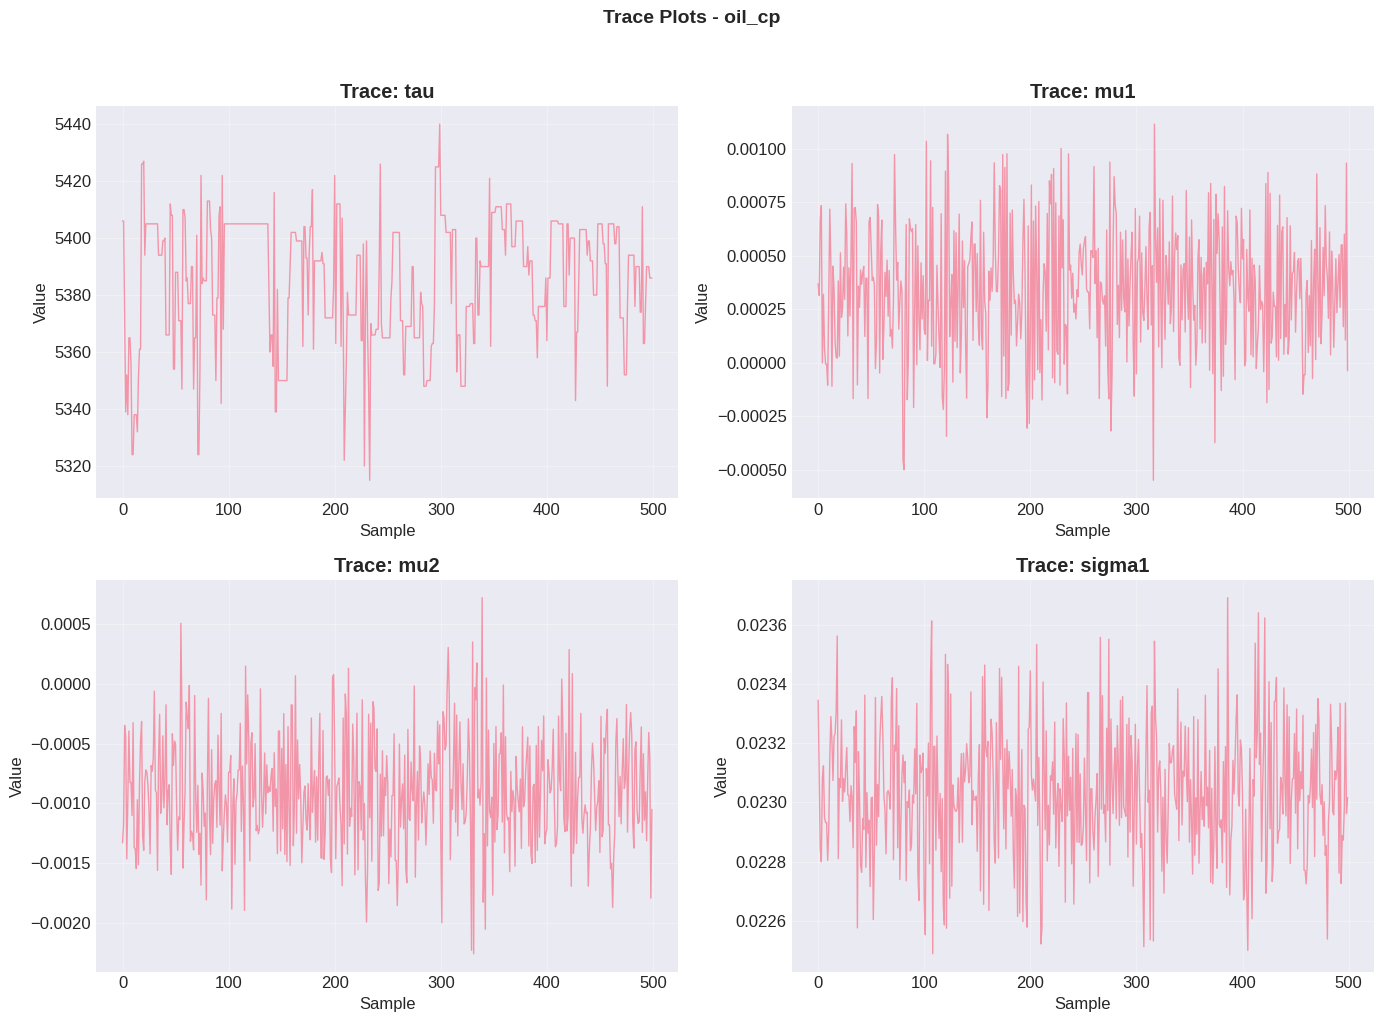

✓ Posterior plots saved to ../reports/task2/oil_cp_posterior_plots.png


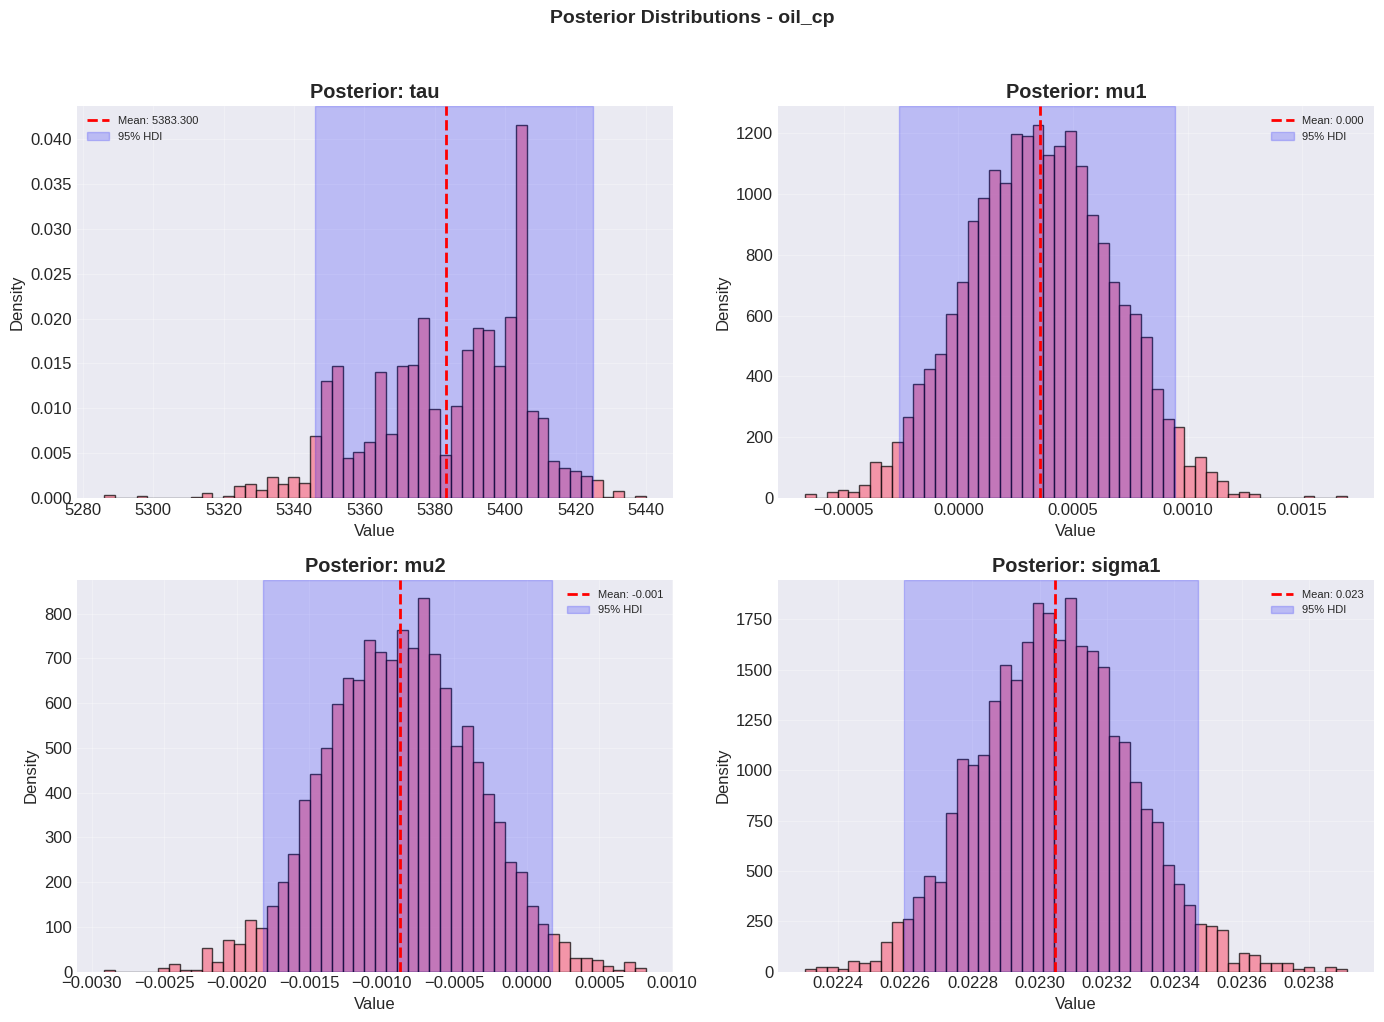

In [29]:
# 5. Analyze convergence
print("\n5. Analyzing convergence...")
conv_stats = analyze_trace(trace)

# 6. Plot diagnostics
print("\n6. Plotting diagnostics...")
plot_diagnostics(trace, model_name="oil_cp", save_dir="../reports/task2")


7. Extracting change point...
✓ Change point plot saved to ../reports/task2/oil_cp_changepoint_plot.png


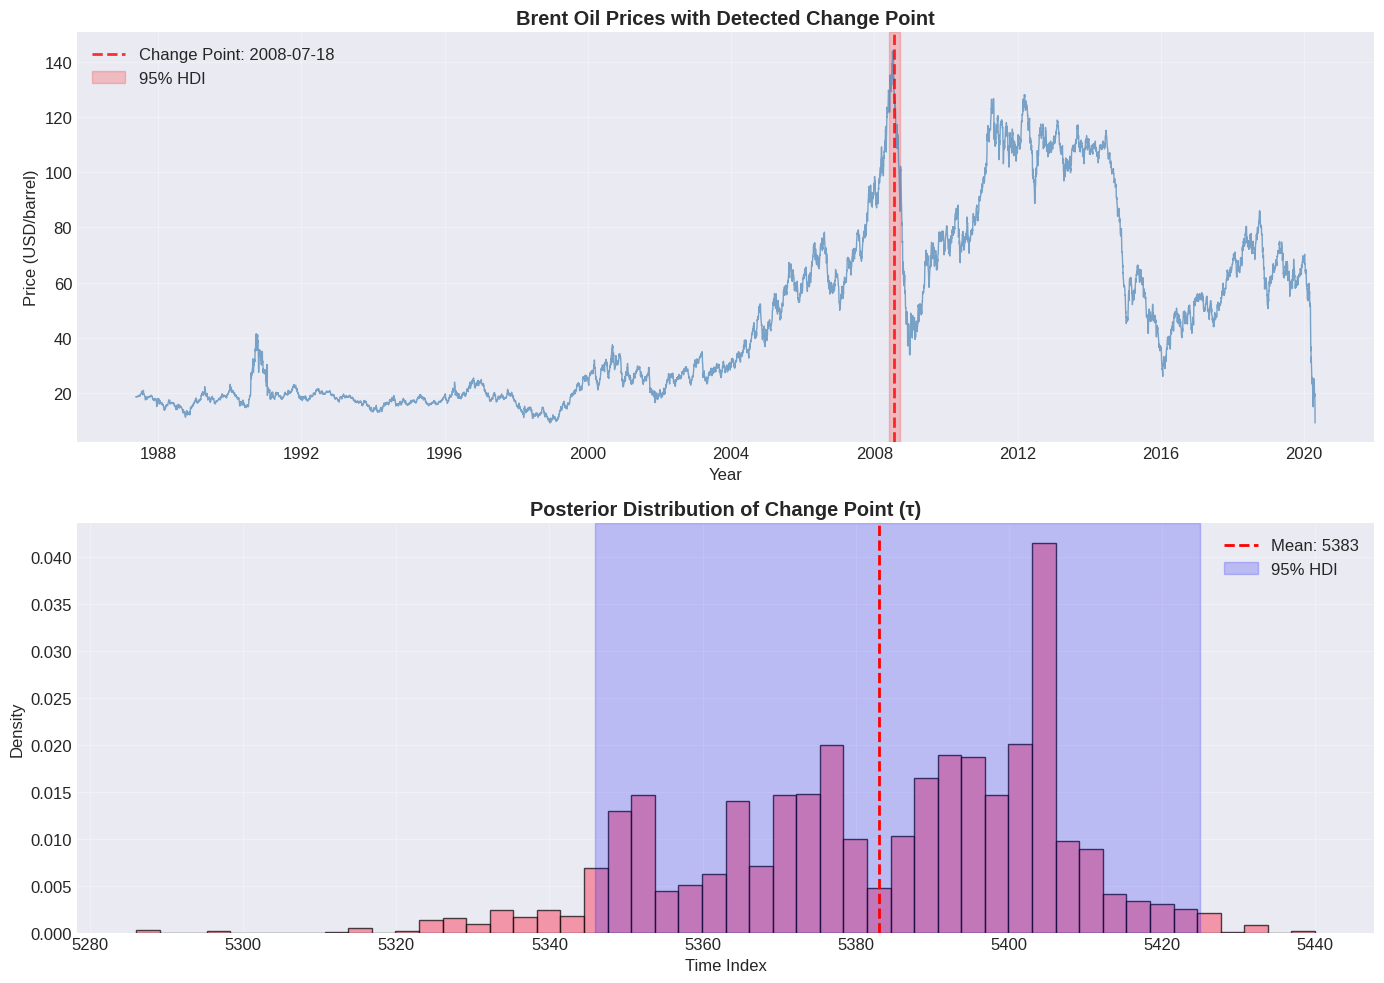

In [30]:
# 7. Extract and plot change point
print("\n7. Extracting change point...")
cp_result = plot_changepoint_on_prices(
    trace, 
    df_prices['Date'].values,  # Use price dates, not return dates
    df_prices['Price'].values,
    model_name="oil_cp",
    save_dir="../reports/task2"
)

In [31]:
# 8. Compare with events
print("\n8. Comparing with historical events...")

def find_nearby_events(change_date, events_df, window_days=90):
    """Find events near the change point."""
    events_df = events_df.copy()
    events_df['Date'] = pd.to_datetime(events_df['Date'])
    window_start = change_date - pd.Timedelta(days=window_days)
    window_end = change_date + pd.Timedelta(days=window_days)
    nearby_events = events_df[(events_df['Date'] >= window_start) & (events_df['Date'] <= window_end)].copy()
    if len(nearby_events) > 0:
        nearby_events['Days_from_Change'] = (nearby_events['Date'] - change_date).dt.days
        nearby_events = nearby_events.sort_values('Days_from_Change', key=abs)
    return nearby_events

if cp_result and 'mean_date' in cp_result:
    nearby_events = find_nearby_events(cp_result['mean_date'], df_enhanced_events, window_days=90)
    print(f"\nEvents within ±90 days of change point ({cp_result['mean_date'].date()}):")
    print("-" * 80)
    if len(nearby_events) > 0:
        for _, event in nearby_events.iterrows():
            days = event['Days_from_Change']
            print(f"• {event['Event_Title']}")
            print(f"  Date: {event['Date'].date()} ({abs(days)} days {'before' if days < 0 else 'after'})")
            print(f"  Type: {event.get('Event_Type', 'N/A')}")
            print(f"  Region: {event.get('Region_Country', 'N/A')}")
            print()
    else:
        print("No events found within ±90 days")
else:
    print("Could not find change point for event comparison")


8. Comparing with historical events...

Events within ±90 days of change point (2008-07-18):
--------------------------------------------------------------------------------
• Oil Hits Record High ~$147
  Date: 2008-07-01 (17 days before)
  Type: Demand/Supply Shock
  Region: Global

• Lehman Brothers Collapse
  Date: 2008-09-15 (59 days after)
  Type: Financial Crisis
  Region: U.S./Global



In [32]:
# 9. Quantify parameter changes
print("\n9. Quantifying parameter changes...")

def quantify_parameter_changes(trace):
    """Quantify changes in regime parameters."""
    param_names = [p for p in trace.posterior.data_vars if not p.startswith(('chain', 'draw', 'tau'))]
    print(f"Available parameters: {param_names}")
    results = {}
    for prefix in ['mu', 'sigma']:
        prefixed_params = [p for p in param_names if prefix in p.lower()]
        if len(prefixed_params) >= 2:
            param1_name = prefixed_params[0]
            param2_name = prefixed_params[1]
            try:
                param1_samples = trace.posterior[param1_name].values.flatten()
                param2_samples = trace.posterior[param2_name].values.flatten()
                change_samples = param2_samples - param1_samples
                change_mean = np.mean(change_samples)
                change_std = np.std(change_samples)
                change_hdi = az.hdi(change_samples, hdi_prob=0.95)
                results[prefix] = {
                    'param1': param1_name,
                    'param2': param2_name,
                    'change_mean': float(change_mean),
                    'change_std': float(change_std),
                    'hdi_95': [float(change_hdi[0]), float(change_hdi[1])],
                    'probability_increase': float(np.mean(change_samples > 0))
                }
                print(f"\n{prefix.upper()} changes:")
                print(f"  {param1_name} → {param2_name}")
                print(f"  Mean change: {change_mean:.6f}")
                print(f"  95% HDI: [{change_hdi[0]:.6f}, {change_hdi[1]:.6f}]")
                print(f"  Probability of increase: {results[prefix]['probability_increase']:.2%}")
            except Exception as e:
                print(f"  Could not quantify {prefix} changes: {e}")
    return results

param_changes = quantify_parameter_changes(trace)


9. Quantifying parameter changes...
Available parameters: ['oil_cp::tau', 'oil_cp::mu1', 'oil_cp::mu2', 'oil_cp::sigma1', 'oil_cp::sigma2']

MU changes:
  oil_cp::mu1 → oil_cp::mu2
  Mean change: -0.001234
  95% HDI: [-0.002464, -0.000038]
  Probability of increase: 2.33%

SIGMA changes:
  oil_cp::sigma1 → oil_cp::sigma2
  Mean change: 0.004848
  95% HDI: [0.004007, 0.005690]
  Probability of increase: 100.00%


In [36]:
def calculate_event_impact(event_date, price_series, window_days=30):
    """Calculate price impact around an event using pandas Series."""
    try:
        # Find closest date in price series
        # Create a Series of absolute time differences
        time_diffs = pd.Series(np.abs((price_series.index - event_date).total_seconds()),
                              index=price_series.index)
        
        # Find the index of the minimum time difference
        closest_idx = time_diffs.idxmin()
        closest_date = closest_idx
        
        # Define window
        start_date = closest_date - pd.Timedelta(days=window_days)
        end_date = closest_date + pd.Timedelta(days=window_days)
        
        # Extract window data
        window_mask = (price_series.index >= start_date) & (price_series.index <= end_date)
        window_data = price_series[window_mask]
        
        if len(window_data) > 2:  # Need at least some data before and after
            # Split into pre and post event
            pre_mask = window_data.index < closest_date
            post_mask = window_data.index > closest_date
            
            pre_data = window_data[pre_mask]
            post_data = window_data[post_mask]
            
            if len(pre_data) > 0 and len(post_data) > 0:
                pre_avg = pre_data.mean()
                post_avg = post_data.mean()
                pct_change = ((post_avg - pre_avg) / pre_avg) * 100 if pre_avg != 0 else 0
                
                return {
                    'event_date': event_date,
                    'closest_price_date': closest_date,
                    'pre_avg': float(pre_avg),
                    'post_avg': float(post_avg),
                    'absolute_change': float(post_avg - pre_avg),
                    'percent_change': float(pct_change),
                    'window_days': window_days,
                    'days_difference': (closest_date - event_date).days
                }
    except Exception as e:
        print(f"Error calculating impact: {e}")
    
    return None

# Create price series for impact analysis
price_series = pd.Series(df_prices['Price'].values, index=df_prices['Date'])

# Calculate impact for events near change point
if cp_result and 'mean_date' in cp_result and len(nearby_events) > 0:
    print("\nEvent Impact Analysis:")
    print("-" * 80)
    
    for idx, event in nearby_events.head(3).iterrows():
        impact = calculate_event_impact(
            event['Date'], 
            price_series,
            window_days=30
        )
        
        if impact:
            print(f"\n{event['Event_Title']}:")
            print(f"  Event date: {event['Date'].date()}")
            print(f"  Closest price date: {impact['closest_price_date'].date()}")
            print(f"  Pre-event avg (30 days): ${impact['pre_avg']:.2f}")
            print(f"  Post-event avg (30 days): ${impact['post_avg']:.2f}")
            print(f"  Change: ${impact['absolute_change']:+.2f} ({impact['percent_change']:+.2f}%)")
            
            # Save impact data
            impact_data = {
                'event': event.to_dict(),
                'impact': impact,
                'change_point': cp_result['mean_date'].isoformat() if 'mean_date' in cp_result else None
            }
            
            impact_path = f"../reports/task2/event_impact_{idx}.json"
            with open(impact_path, 'w') as f:
                json.dump(impact_data, f, indent=2, default=str)
            
            print(f"  ✓ Impact data saved to {impact_path}")


Event Impact Analysis:
--------------------------------------------------------------------------------

Oil Hits Record High ~$147:
  Event date: 2008-07-01
  Closest price date: 2008-07-01
  Pre-event avg (30 days): $132.32
  Post-event avg (30 days): $132.34
  Change: $+0.02 (+0.01%)
  ✓ Impact data saved to ../reports/task2/event_impact_9.json

Lehman Brothers Collapse:
  Event date: 2008-09-15
  Closest price date: 2008-09-15
  Pre-event avg (30 days): $106.39
  Post-event avg (30 days): $88.25
  Change: $-18.14 (-17.05%)
  ✓ Impact data saved to ../reports/task2/event_impact_10.json


In [37]:
# 11. Generate insights report
print("\n11. Generating insights report...")

def generate_insights_report(cp_result, param_changes, nearby_events, model_name="oil_cp"):
    """Generate insights report."""
    report = []
    report.append("# Bayesian Change Point Analysis - Insights Report")
    report.append(f"## Model: {model_name}")
    report.append(f"## Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append("")
    report.append("## 1. Detected Change Point")
    if cp_result and 'mean_date' in cp_result:
        report.append(f"- **Date**: {cp_result['mean_date'].date()}")
        report.append(f"- **Time Index**: {cp_result.get('mean_tau', 'N/A')}")
        report.append(f"- **Posterior Probability**: {cp_result.get('probability', 0):.2%}")
        if 'hdi_95_dates' in cp_result:
            report.append(f"- **95% HDI**: {cp_result['hdi_95_dates'][0].date()} to {cp_result['hdi_95_dates'][1].date()}")
    else:
        report.append("- No change point detected")
    report.append("")
    report.append("## 2. Parameter Changes")
    if param_changes:
        if 'mu' in param_changes:
            mu_changes = param_changes['mu']
            report.append("### Mean Returns:")
            report.append(f"- Change: {mu_changes['change_mean']:.6f}")
            report.append(f"- 95% HDI: [{mu_changes['hdi_95'][0]:.6f}, {mu_changes['hdi_95'][1]:.6f}]")
            report.append(f"- Probability of increase: {mu_changes['probability_increase']:.2%}")
            report.append("")
        if 'sigma' in param_changes:
            sigma_changes = param_changes['sigma']
            report.append("### Volatility:")
            report.append(f"- Change: {sigma_changes['change_mean']:.6f}")
            report.append(f"- 95% HDI: [{sigma_changes['hdi_95'][0]:.6f}, {sigma_changes['hdi_95'][1]:.6f}]")
            report.append(f"- Probability of increase: {sigma_changes['probability_increase']:.2%}")
    else:
        report.append("- Could not quantify parameter changes")
    report.append("")
    report.append("## 3. Event Correlations")
    if nearby_events is not None and len(nearby_events) > 0:
        report.append("### Events within ±90 days of change point:")
        for _, event in nearby_events.head(5).iterrows():
            days = event.get('Days_from_Change', 0)
            report.append(f"- **{event['Event_Title']}**")
            report.append(f"  - Date: {event['Date'].date()} ({abs(days)} days {'before' if days < 0 else 'after'})")
            report.append(f"  - Type: {event.get('Event_Type', 'N/A')}")
            report.append(f"  - Region: {event.get('Region_Country', 'N/A')}")
    else:
        report.append("- No events found within ±90 days")
    report.append("")
    report.append("## 4. Investment Implications")
    report.append("### Based on the detected change point:")
    if cp_result and 'mean_date' in cp_result:
        report.append(f"1. **Regime Shift Detected**: A structural break occurred around {cp_result['mean_date'].date()}")
        report.append("2. **Market Implications**: ")
        if 'mu' in param_changes:
            mu_change = param_changes['mu']['change_mean']
            if mu_change > 0:
                report.append("   - Average returns INCREASED after the change point")
                report.append("   - Consider strategies benefiting from higher returns")
            else:
                report.append("   - Average returns DECREASED after the change point")
                report.append("   - Consider defensive or hedging strategies")
        if 'sigma' in param_changes:
            sigma_change = param_changes['sigma']['change_mean']
            if sigma_change > 0:
                report.append("   - Volatility INCREASED after the change point")
                report.append("   - Increase risk management measures")
                report.append("   - Consider options strategies for volatility exposure")
            else:
                report.append("   - Volatility DECREASED after the change point")
                report.append("   - Potentially lower risk environment")
                report.append("   - May allow for more aggressive positioning")
    report.append("")
    report.append("## 5. Limitations")
    report.append("- **Model simplicity**: Single change point model may oversimplify")
    report.append("- **Correlation ≠ causation**: Events may correlate but not cause changes")
    report.append("- **Data frequency**: Daily data may miss intraday dynamics")
    report.append("- **Assumptions**: Normal distribution for returns")
    report.append("")
    return "\n".join(report)

insights_report = generate_insights_report(cp_result, param_changes, nearby_events)
report_path = "../reports/task2/insights_report.md"
with open(report_path, 'w') as f:
    f.write(insights_report)
print(f"✓ Insights report saved to {report_path}")


11. Generating insights report...
✓ Insights report saved to ../reports/task2/insights_report.md


In [38]:
# 12. Save all results
print("\n12. Saving all results...")

def save_results(trace, cp_result, param_changes, model_name="oil_cp", output_dir="../models"):
    """Save all analysis results."""
    os.makedirs(output_dir, exist_ok=True)
    trace_path = os.path.join(output_dir, f"{model_name}_trace.nc")
    try:
        trace.to_netcdf(trace_path)
        print(f"✓ Trace saved to {trace_path}")
    except Exception:
        print("✗ Could not save trace (file may be too large)")
    results_summary = {
        'model_name': model_name,
        'timestamp': datetime.now().isoformat(),
        'convergence': conv_stats,
        'change_point': cp_result,
        'parameter_changes': param_changes,
        'data_info': {
            'n_observations': len(log_returns),
            'date_range': {
                'start': df_prices['Date'].min().isoformat(),
                'end': df_prices['Date'].max().isoformat()
            }
        }
    }
    results_path = os.path.join(output_dir, f"{model_name}_results.json")
    with open(results_path, 'w') as f:
        json.dump(results_summary, f, indent=2, default=str)
    print(f"✓ Results summary saved to {results_path}")

save_results(trace, cp_result, param_changes)


12. Saving all results...
✓ Trace saved to ../models/oil_cp_trace.nc
✓ Results summary saved to ../models/oil_cp_results.json


In [39]:
# 13. Final summary
print("\n" + "="*70)
print("TASK 2 COMPLETE - SUMMARY")
print("="*70)

print("\n✅ Completed Tasks:")
print("1. ✓ Built and sampled Bayesian change point model")
print("2. ✓ Analyzed MCMC convergence")
print("3. ✓ Identified structural break in oil returns")
print("4. ✓ Quantified parameter changes")
print("5. ✓ Compared with historical events")
print("6. ✓ Generated insights report")
print("7. ✓ Saved all results")

if cp_result:
    print(f"\n📊 Key Finding:")
    print(f"- Detected change point: {cp_result.get('mean_date', 'N/A')}")
    if 'mu' in param_changes:
        mu_change = param_changes['mu']['change_mean']
        print(f"- Mean return change: {mu_change:.6f}")
    if nearby_events is not None and len(nearby_events) > 0:
        closest_event = nearby_events.iloc[0]
        days = closest_event.get('Days_from_Change', 0)
        print(f"- Closest event: {closest_event['Event_Title']} ({abs(days)} days {'before' if days < 0 else 'after'})")

print("\n📁 Output Files:")
print(f"- Reports: reports/task2/")
print(f"- Models: models/")
print(f"- Visualizations: reports/task2/*.png")

print("\n📈 Next Steps:")
print("1. Review insights report: reports/task2/insights_report.md")
print("2. Examine the visualizations")
print("3. Proceed to Task 3 dashboard development")

print("\n" + "="*70)


TASK 2 COMPLETE - SUMMARY

✅ Completed Tasks:
1. ✓ Built and sampled Bayesian change point model
2. ✓ Analyzed MCMC convergence
3. ✓ Identified structural break in oil returns
4. ✓ Quantified parameter changes
5. ✓ Compared with historical events
6. ✓ Generated insights report
7. ✓ Saved all results

📊 Key Finding:
- Detected change point: 2008-07-18 00:00:00
- Mean return change: -0.001234
- Closest event: Oil Hits Record High ~$147 (17 days before)

📁 Output Files:
- Reports: reports/task2/
- Models: models/
- Visualizations: reports/task2/*.png

📈 Next Steps:
1. Review insights report: reports/task2/insights_report.md
2. Examine the visualizations
3. Proceed to Task 3 dashboard development



## Task 2 Insights Script
Run `python scripts/generate_task2_insights.py` after saving model outputs.